In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
data = pd.read_csv("path_to_file\\train.csv", index_col='id')
data.sample(2)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
id,,,,,,,,,,,,,,,,,,,,,
27290,2015-01-14,85,61.0,9.0,10.0,2.0,1973.0,3.0,7.0,3.0,...,136,32,9,41,95,1,36,129,11,18850000
25316,2014-11-26,35,20.0,8.0,12.0,5.0,1968.0,1.0,9.0,3.0,...,15,3,1,10,10,0,1,49,7,6900000


In [3]:
data['year'] = pd.DatetimeIndex(data['timestamp']).year
data['month'] = pd.DatetimeIndex(data['timestamp']).month
data['day'] = pd.DatetimeIndex(data['timestamp']).day
data = data.drop(columns=['timestamp'])
data.sample(2)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,year,month,day
id,,,,,,,,,,,,,,,,,,,,,
30118,30,20.0,1.0,5.0,5.0,1960.0,1.0,5.0,3.0,Investment,...,11,28,0,6,97,4,1000000,2015,6,4
17271,99,66.0,4.0,9.0,2.0,1962.0,4.0,8.0,2.0,Investment,...,102,153,1,42,132,16,16900000,2014,4,11


чертова туча непонятных колонок, выберем какие-то из dictionary

In [4]:
data_features = data[['year', 'month', 'day', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year',
                     'num_room', 'kitch_sq', 'state']]
data_result = data['price_doc']
data_features.sample(2)

,year,month,day,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state
id,,,,,,,,,,,,
11022,2013,10,7,77,77.0,7.0,1.0,1.0,NaN,3.0,1.0,NaN
26692,2014,12,17,38,23.0,8.0,12.0,5.0,1968.0,2.0,5.0,3.0


In [5]:
data_features.dtypes

year            int64
month           int64
day             int64
full_sq         int64
life_sq       float64
floor         float64
max_floor     float64
material      float64
build_year    float64
num_room      float64
kitch_sq      float64
state         float64
dtype: object

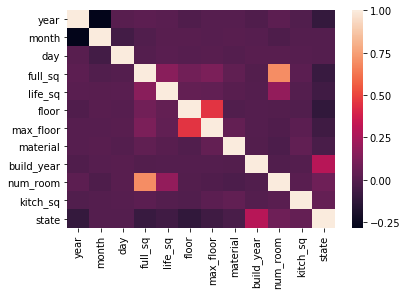

In [6]:
sea.heatmap(data_features.corr())

в среднем видим довольно слабую корреляцию между параметрами (ну, не считая num_room и full_sq каких-нибудь)

D:\anaconda_python\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


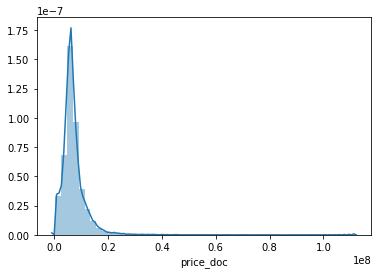

In [7]:
sea.distplot(data_result)

In [8]:
ft_train, ft_test, res_train, res_test = train_test_split(data_features, data_result, random_state=13)

In [9]:
xgmr = xgb.XGBRegressor()
params = {
    "max_depth" : [3, 5],
    "learning_rate" : [0.1, 0.2, 0.3],
    "subsample" : [0.8, 0.9, 1],
    "n_estimators" : [50, 100, 200]
}
xgb_cv = GridSearchCV(xgmr, params, cv=3)
xgb_cv.fit(ft_train, res_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 5], 'learning_rate': [0.1, 0.2, 0.3], 'subsample': [0.8, 0.9, 1], 'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [10]:
xgb_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}

In [11]:
mean_absolute_error(res_test, xgb_cv.best_estimator_.predict(ft_test)), mean_squared_error(res_test, xgb_cv.best_estimator_.predict(ft_test))

(1866094.2870011814, 10516556100217.762)

D:\anaconda_python\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


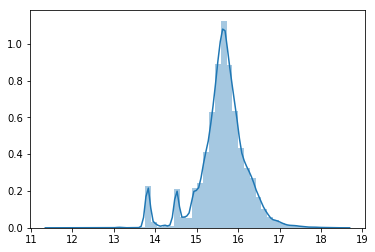

In [12]:
tmp = np.log(data_result.values)
sea.distplot(tmp)

In [13]:
data_result = tmp

In [14]:
ft_train, ft_test, res_train, res_test = train_test_split(data_features, data_result, random_state=13)

In [15]:
xgmr = xgb.XGBRegressor()
params = {
    "max_depth" : [3, 5],
    "learning_rate" : [0.1, 0.2],
    "subsample" : [0.8, 0.9, 1],
    "n_estimators" : [50, 100, 200]
}
xgb_cv = GridSearchCV(xgmr, params, cv=3)
xgb_cv.fit(ft_train, res_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 5], 'learning_rate': [0.1, 0.2], 'subsample': [0.8, 0.9, 1], 'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
xgb_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}

In [17]:
mean_absolute_error(res_test, xgb_cv.best_estimator_.predict(ft_test)), mean_squared_error(res_test, xgb_cv.best_estimator_.predict(ft_test))

(0.3222909033826151, 0.24513584403334093)

In [23]:
mean_absolute_error(np.exp(res_test), np.exp(xgb_cv.best_estimator_.predict(ft_test))), mean_squared_error(np.exp(res_test), np.exp(xgb_cv.best_estimator_.predict(ft_test)))

(2015429.1970825673, 11078448477904.277)

чет особо ничего не изменилось, даже чуть хуже стало ._.